### paul - https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch/

# [UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/)
> Track healthy organs in medical scans to improve cancer treatment

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/27923/logos/header.png?t=2021-06-02-20-30-25">

# ⚽ Methodlogy
* In this notebook I'll demonstrate how to train **Unet** model using PyTorch.
* For mask I'll be using pre-computed mask from [here](https://www.kaggle.com/datasets/awsaf49/uwmgi-mask-dataset)
* As there are overlaps between **Stomach**, **Large Bowel** & **Small Bowel** classes, this is a **MultiLabel Segmentation** task, so final activaion should be `sigmoid` instead of `softmax`.
* For data split I'll be using **StratifiedGroupFold** to avoid data leakage due to `case` and to stratify `empty` and `non-empty` mask cases.
* You can play with different models and losses.

## Please Upvote if you Find this Useful :)

# 📒 Notebooks
📌 **UNet**:
* Train: [UWMGI: Unet [Train] [PyTorch]](https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch/)
* Infer: [UWMGI: Unet [Infer] [PyTorch]](https://www.kaggle.com/code/awsaf49/uwmgi-unet-infer-pytorch/)

# 🛠 Install Libraries

In [1]:
!pip install -q segmentation_models_pytorch
!pip install -qU wandb
!pip install -q scikit-learn==1.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.3 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0 which is incompatible.


# 📚 Import Libraries 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import rasterio
from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# ⭐ WandB

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management. Some of the cool features of **W&B**:

* Track, compare, and visualize ML experiments
* Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.
* Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.

In [4]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

To use your W&B account,
Go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. 
Get your W&B access token from here: https://wandb.ai/authorize


# ⚙️ Configuration 

In [5]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'Baseline'
    comment       = 'unet-efficientnet_b2-256x256'
    model_name    = 'Unet'
    backbone      = 'efficientnet-b2'
    train_bs      = 84
    valid_bs      = train_bs*2
    img_size      = [256, 256]
    epochs        = 30
    lr            = 4e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# ❗ Reproducibility

In [6]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


# 📖 Meta Data

* Files
    * train.csv - IDs and masks for all training objects.
    * sample_submission.csv - a sample submission file in the correct format
    * train - a folder of case/day folders, each containing slice images for a particular case on a given day.

> Note that the image filenames include 4 numbers (ex. `276_276_1.63_1.63.png`). These four numbers are slice height / width (integers in pixels) and heigh/width pixel spacing (floating points in mm). The first two defines the resolution of the slide. The last two record the physical size of each pixel.

* Columns
    * id - unique identifier for object
    * class - the predicted class for the object
    * EncodedPixels - RLE-encoded pixels for the identified object

In [7]:
BASE_PATH  = '/kaggle/input/uw-madison-gi-tract-image-segmentation'

In [8]:
df = pd.read_csv('../input/uwmgi-mask-dataset/uw-madison-gi-tract-image-segmentation/train.csv')
df['empty'] = df.segmentation.map(lambda x: int(pd.isna(x)))

df2 = df.groupby(['id'])['class'].agg(list).to_frame().reset_index()
df2 = df2.merge(df.groupby(['id'])['segmentation'].agg(list), on=['id'])
# df = df[['id','case','day','image_path','mask_path','height','width', 'empty']]

df = df.drop(columns=['segmentation', 'class'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df.head()

id  case  day  slice  \
0  case123_day20_slice_0001   123   20      1   
1  case123_day20_slice_0002   123   20      2   
2  case123_day20_slice_0003   123   20      3   
3  case123_day20_slice_0004   123   20      4   
4  case123_day20_slice_0005   123   20      5   

                                          image_path  height  width  \
0  /kaggle/input/uw-madison-gi-tract-image-segmen...     266    266   
1  /kaggle/input/uw-madison-gi-tract-image-segmen...     266    266   
2  /kaggle/input/uw-madison-gi-tract-image-segmen...     266    266   
3  /kaggle/input/uw-madison-gi-tract-image-segmen...     266    266   
4  /kaggle/input/uw-madison-gi-tract-image-segmen...     266    266   

                                           mask_path  empty  \
0  /kaggle/input/uwmgi-mask-dataset/uw-madison-gi...      1   
1  /kaggle/input/uwmgi-mask-dataset/uw-madison-gi...      1   
2  /kaggle/input/uwmgi-mask-dataset/uw-madison-gi...      1   
3  /kaggle/input/uwmgi-mask-dataset/uw-madison-gi...      1   
4  /kaggle/input/uwmgi-mask-dataset/uw-madison-gi...      1   

                                 class     segmentation  
0  [large_bowel, small_bowel, stomach]  [nan, nan, nan]  
1  [large_bowel, small_bowel, stomach]  [nan, nan, nan]  
2  [large_bowel, small_bowel, stomach]  [nan, nan, nan]  
3  [large_bowel, small_bowel, stomach]  [nan, nan, nan]  
4  [large_bowel, small_bowel, stomach]  [nan, nan, nan]

## Class Distribution

In [9]:
df['empty'].value_counts().plot.bar()

# 🔨 Utility

## Mask

In [10]:
def id2mask(id_):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['stomach', 'large_bowel', 'small_bowel']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

## Image

In [11]:
def load_img(path, mask=False):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype('float32') # original is uint16
    if not mask:
        mx = np.max(img)
        if mx:
            img = (img/mx) # scale image to [0, 1]
#         img = img.astype('uint8')
    else:
        img = img/255.0 # mask ->  [0, 1]
    return img

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Stomach", "Large Bowel", "Small Bowel"]
        plt.legend(handles,labels)
    plt.axis('off')

# 📁 Create Folds

In [12]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['empty'], groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','empty'])['id'].count())

fold  empty
0.0   0        2655
      1        4577
1.0   0        3303
      1        5225
2.0   0        2775
      1        5161
3.0   0        2503
      1        4841
4.0   0        2849
      1        4607
Name: id, dtype: int64

# 🍚 Dataset

In [13]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, label=True, transforms=None):
        self.df         = df
        self.label      = label
        self.img_paths  = df['image_path'].tolist()
        self.msk_paths  = df['mask_path'].tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = []
        img = load_img(img_path, mask=False)
        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_img(msk_path, mask=True)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            msk = np.transpose(msk, (2, 0, 1))
            return img, msk
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            return img

# 🌈 Augmentations

In [14]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size),
        A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=5, p=0.5),
#         A.OneOf([
#             A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
#             A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
#         ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ToTensorV2()], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size),
        ToTensorV2()], p=1.0)
}

# 🍰 DataLoader

In [15]:
def prepare_loaders(fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    if debug:
        train_df = train_df.head(32*5)
        valid_df = valid_df.head(32*3)
    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs if not debug else 20, 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 20, 
                              num_workers=4, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader


In [16]:
train_loader, valid_loader = prepare_loaders(fold=0, debug=True)

In [17]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([20, 1, 256, 256]), torch.Size([20, 3, 256, 256]))

# 📈 Visualization

In [18]:
def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

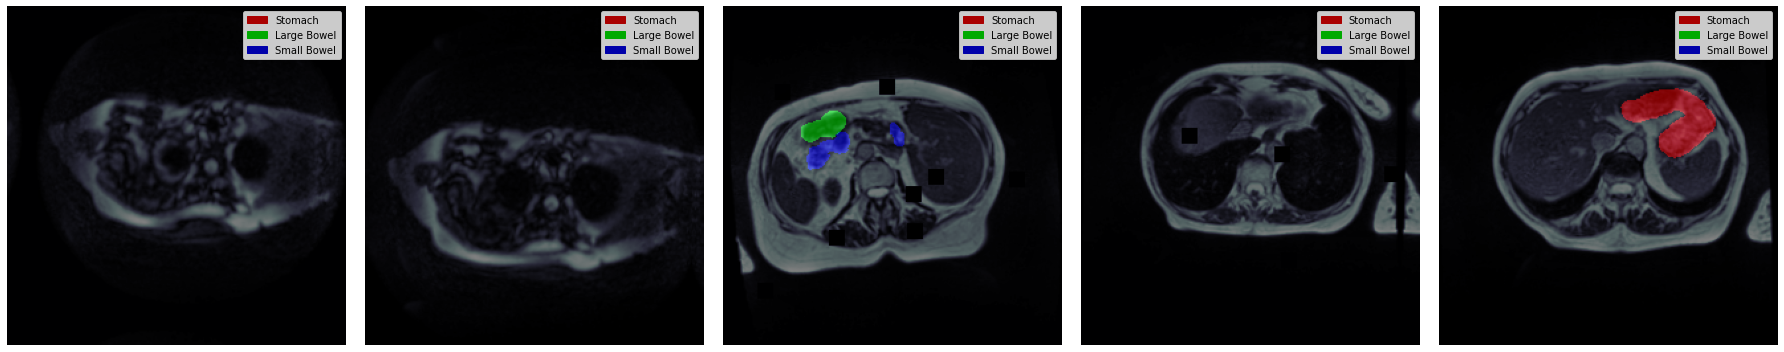

In [19]:
plot_batch(imgs, msks, size=5)

In [20]:
import gc
gc.collect()

16003

# 📦 Model


In [21]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# 🔧 Loss Function

In [22]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
Jaccard     = smp.losses.JaccardLoss(mode='multilabel', from_logits=False)
Dice        = smp.losses.DiceLoss(mode='multilabel', from_logits=False)
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()

def criterion(y_pred, y_true):
    return JaccardLoss(y_pred, y_true)

# 🚄 Training Function

In [23]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

# 👀 Validation Function

In [24]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = (nn.Sigmoid()(y_pred)>0.5).to(torch.float32)
        y_true = masks.to(torch.float32)
        val_dice    = 1. - Dice(y_true, y_pred).cpu().detach().numpy()
        val_jaccard = 1. - Jaccard(y_true, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

# 🏃 Run Training

In [25]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        # Log the metrics
        wandb.log({"Train Loss": train_loss, 
                   "Valid Loss": val_loss,
                   "Valid Dice": val_dice,
                   "Valid Jaccard": val_jaccard,
                   "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        # deep copy the model
        if val_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            run.summary["Best Dice"]    = best_dice
            run.summary["Best Jaccard"] = best_jaccard
            run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

# 🔍 Optimizer

<img src="https://mlfromscratch.com/content/images/2019/12/saddle.gif" width=500>

In [26]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [27]:
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

# 🚅 Training

In [28]:
for fold in range(1):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='uw-maddison-gi-tract', 
                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                     anonymous=anonymous,
                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
                     group=CFG.comment,
                    )
    train_loader, valid_loader = prepare_loaders(fold=fold, debug=CFG.debug)
    model     = build_model()
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(model, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
    run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))

###############
### Fold: 0
###############


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


cuda: Tesla P100-PCIE-16GB

Epoch 1/30

Valid : 100%|██████████| 44/44 [00:52<00:00,  1.18s/it, gpu_memory=7.73 GB, lr=0.00399, valid_loss=0.7195]


Valid Dice: 0.4302 | Valid Jaccard: 0.2894
Valid Score Improved (-inf ---> 0.4302)
Model Saved


Epoch 2/30

Valid : 100%|██████████| 44/44 [00:43<00:00,  1.02it/s, gpu_memory=7.78 GB, lr=0.00395, valid_loss=0.5221]


Valid Dice: 0.6273 | Valid Jaccard: 0.4824
Valid Score Improved (0.4302 ---> 0.6273)
Model Saved


Epoch 3/30

Valid : 100%|██████████| 44/44 [00:43<00:00,  1.02it/s, gpu_memory=7.80 GB, lr=0.00389, valid_loss=0.6069]


Valid Dice: 0.5360 | Valid Jaccard: 0.4065


Epoch 4/30

Valid : 100%|██████████| 44/44 [00:43<00:00,  1.02it/s, gpu_memory=7.89 GB, lr=0.00381, valid_loss=0.4803]


Valid Dice: 0.6685 | Valid Jaccard: 0.5305
Valid Score Improved (0.6273 ---> 0.6685)
Model Saved


Epoch 5/30

Valid : 100%|██████████| 44/44 [00:43<00:00,  1.00it/s, gpu_memory=7.89 GB, lr=0.00371, valid_loss=0.4302]


Valid Dice: 0.7208 | Valid Jaccard: 0.5794
Valid Score Improved (0.6685 ---> 0.7208)
Model Saved


Epoch 6/30

Valid : 100%|██████████| 44/44 [00:46<00:00,  1.05s/it, gpu_memory=7.90 GB, lr=0.00359, valid_loss=0.4004]


Valid Dice: 0.7451 | Valid Jaccard: 0.6086
Valid Score Improved (0.7208 ---> 0.7451)
Model Saved


Epoch 7/30

Valid : 100%|██████████| 44/44 [00:44<00:00,  1.01s/it, gpu_memory=7.81 GB, lr=0.00345, valid_loss=0.4068]


Valid Dice: 0.7401 | Valid Jaccard: 0.6022


Epoch 8/30

Valid : 100%|██████████| 44/44 [00:44<00:00,  1.02s/it, gpu_memory=7.81 GB, lr=0.00329, valid_loss=0.4011]


Valid Dice: 0.7446 | Valid Jaccard: 0.6078


Epoch 9/30

Valid : 100%|██████████| 44/44 [00:44<00:00,  1.02s/it, gpu_memory=7.81 GB, lr=0.00312, valid_loss=0.4194]


Valid Dice: 0.7291 | Valid Jaccard: 0.5899


Epoch 10/30

Valid : 100%|██████████| 44/44 [00:42<00:00,  1.03it/s, gpu_memory=7.81 GB, lr=0.00293, valid_loss=0.3798]


Valid Dice: 0.7607 | Valid Jaccard: 0.6286
Valid Score Improved (0.7451 ---> 0.7607)
Model Saved


Epoch 11/30

Valid : 100%|██████████| 44/44 [00:44<00:00,  1.01s/it, gpu_memory=7.81 GB, lr=0.00274, valid_loss=0.4286]


Valid Dice: 0.7199 | Valid Jaccard: 0.5808


Epoch 12/30

Valid : 100%|██████████| 44/44 [00:42<00:00,  1.04it/s, gpu_memory=7.90 GB, lr=0.00253, valid_loss=0.4264]


Valid Dice: 0.7146 | Valid Jaccard: 0.5830


Epoch 13/30

Valid : 100%|██████████| 44/44 [00:43<00:00,  1.01it/s, gpu_memory=7.81 GB, lr=0.00232, valid_loss=0.3843]


Valid Dice: 0.7580 | Valid Jaccard: 0.6242


Epoch 14/30

Valid : 100%|██████████| 44/44 [00:41<00:00,  1.07it/s, gpu_memory=7.90 GB, lr=0.00210, valid_loss=0.3833]


Valid Dice: 0.7592 | Valid Jaccard: 0.6252


Epoch 15/30

Valid : 100%|██████████| 44/44 [00:42<00:00,  1.03it/s, gpu_memory=7.81 GB, lr=0.00189, valid_loss=0.3967]


Valid Dice: 0.7481 | Valid Jaccard: 0.6120


Epoch 16/30

Valid : 100%|██████████| 44/44 [00:45<00:00,  1.02s/it, gpu_memory=7.90 GB, lr=0.00167, valid_loss=0.3616]


Valid Dice: 0.7767 | Valid Jaccard: 0.6464
Valid Score Improved (0.7607 ---> 0.7767)
Model Saved


Epoch 17/30

Valid : 100%|██████████| 44/44 [00:41<00:00,  1.06it/s, gpu_memory=7.81 GB, lr=0.00146, valid_loss=0.3621]


Valid Dice: 0.7761 | Valid Jaccard: 0.6458


Epoch 18/30

Valid : 100%|██████████| 44/44 [00:41<00:00,  1.06it/s, gpu_memory=7.81 GB, lr=0.00125, valid_loss=0.3579]


Valid Dice: 0.7780 | Valid Jaccard: 0.6500
Valid Score Improved (0.7767 ---> 0.7780)
Model Saved


Epoch 19/30

Valid : 100%|██████████| 44/44 [00:45<00:00,  1.04s/it, gpu_memory=7.81 GB, lr=0.00106, valid_loss=0.3669]


Valid Dice: 0.7713 | Valid Jaccard: 0.6412


Epoch 20/30

Valid : 100%|██████████| 44/44 [00:42<00:00,  1.04it/s, gpu_memory=7.90 GB, lr=0.00087, valid_loss=0.3566]


Valid Dice: 0.7794 | Valid Jaccard: 0.6513
Valid Score Improved (0.7780 ---> 0.7794)
Model Saved


Epoch 21/30

Valid : 100%|██████████| 44/44 [00:41<00:00,  1.06it/s, gpu_memory=7.81 GB, lr=0.00070, valid_loss=0.3521]


Valid Dice: 0.7832 | Valid Jaccard: 0.6556
Valid Score Improved (0.7794 ---> 0.7832)
Model Saved


Epoch 22/30

Valid : 100%|██████████| 44/44 [00:42<00:00,  1.04it/s, gpu_memory=7.81 GB, lr=0.00054, valid_loss=0.3508]


Valid Dice: 0.7839 | Valid Jaccard: 0.6569
Valid Score Improved (0.7832 ---> 0.7839)
Model Saved


Epoch 23/30

Valid : 100%|██████████| 44/44 [00:49<00:00,  1.13s/it, gpu_memory=7.90 GB, lr=0.00040, valid_loss=0.3507]


Valid Dice: 0.7845 | Valid Jaccard: 0.6570
Valid Score Improved (0.7839 ---> 0.7845)
Model Saved


Epoch 24/30

Valid : 100%|██████████| 44/44 [00:42<00:00,  1.04it/s, gpu_memory=7.81 GB, lr=0.00028, valid_loss=0.3518]


Valid Dice: 0.7837 | Valid Jaccard: 0.6559


Epoch 25/30

Valid : 100%|██████████| 44/44 [00:42<00:00,  1.03it/s, gpu_memory=7.81 GB, lr=0.00018, valid_loss=0.3511]


Valid Dice: 0.7840 | Valid Jaccard: 0.6565


Epoch 26/30

Valid : 100%|██████████| 44/44 [00:47<00:00,  1.08s/it, gpu_memory=7.81 GB, lr=0.00010, valid_loss=0.3504]


Valid Dice: 0.7845 | Valid Jaccard: 0.6573


Epoch 27/30

Valid : 100%|██████████| 44/44 [00:43<00:00,  1.01it/s, gpu_memory=7.81 GB, lr=0.00004, valid_loss=0.3478]


Valid Dice: 0.7865 | Valid Jaccard: 0.6599
Valid Score Improved (0.7845 ---> 0.7865)
Model Saved


Epoch 28/30

Valid : 100%|██████████| 44/44 [00:42<00:00,  1.03it/s, gpu_memory=7.81 GB, lr=0.00001, valid_loss=0.3482]


Valid Dice: 0.7861 | Valid Jaccard: 0.6595


Epoch 29/30

Valid : 100%|██████████| 44/44 [00:42<00:00,  1.03it/s, gpu_memory=7.90 GB, lr=0.00000, valid_loss=0.3480]


Valid Dice: 0.7863 | Valid Jaccard: 0.6596


Epoch 30/30

Valid : 100%|██████████| 44/44 [00:47<00:00,  1.08s/it, gpu_memory=7.81 GB, lr=0.00001, valid_loss=0.3489]


Valid Dice: 0.7855 | Valid Jaccard: 0.6587


Training complete in 4h 43m 32s
Best Score: 0.6599



# 🔭 Prediction

In [29]:
test_dataset = BuildDataset(df.query("fold==0 & empty==0").sample(frac=1.0), label=False, transforms=data_transforms['valid'])
test_loader  = DataLoader(test_dataset, batch_size=5, 
                          num_workers=4, shuffle=False, pin_memory=True)
imgs = next(iter(test_loader))
imgs = imgs.to(CFG.device, dtype=torch.float)

preds = []
for fold in range(1):
    model = load_model(f"best_epoch-{fold:02d}.bin")
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)
    
imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

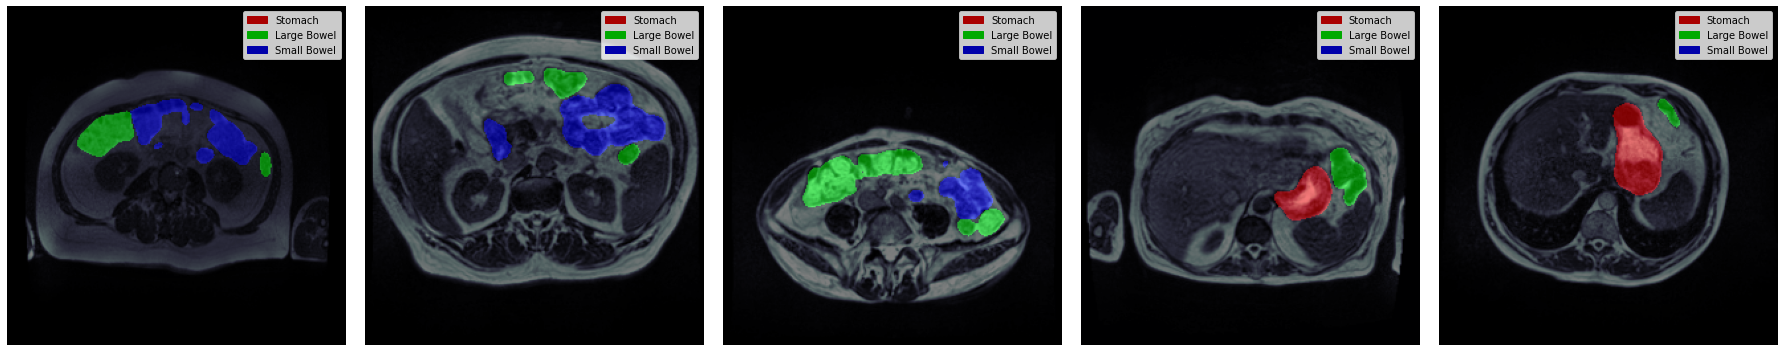

In [30]:
plot_batch(imgs, preds, size=5)

# ✂️ Remove Files

In [31]:
!rm -r ./wandb